<a href="https://colab.research.google.com/github/Smart-Pigs/Depth-Images/blob/main/Weight_Estimation_Square_Cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Make sure you have this folder as shortcut in your drive - /content/gdrive/MyDrive/Morota-video-data/ 

In [1]:
#Mount Google Drive 
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [34]:
cp /content/gdrive/MyDrive/Morota-video-data/DEPTH_INDIVIDUAL/SQUARE/SQUARE_WEEK1-10_512.zip .

In [35]:
!unzip -qq SQUARE_WEEK1-10_512.zip -d .

In [20]:
cp /content/gdrive/MyDrive/Morota-video-data/SEGMENTED_INDIVIDUAL/SQUARE/SQUARE_WEEK1-10_512_masks.zip .

In [21]:
!unzip -qq SQUARE_WEEK1-10_512_masks.zip -d .

warning [SQUARE_WEEK1-10_512_masks.zip]:  76 extra bytes at beginning or within zipfile
  (attempting to process anyway)
error [SQUARE_WEEK1-10_512_masks.zip]:  reported length of central directory is
  -76 bytes too long (Atari STZip zipfile?  J.H.Holm ZIPSPLIT 1.1
  zipfile?).  Compensating...
error:  expected central file header signature not found (file #105682).
  (please check that you have transferred or created the zipfile in the
  appropriate BINARY mode and that you have compiled UnZip properly)


In [ ]:
#!cp /content/gdrive/MyDrive/Morota-video-data/SEGMENTED_INDIVIDUAL/CROPPED/CROPPED_WEEK1-10_720_masks.zip .

In [5]:
#!unzip -qq CROPPED_WEEK1-10_720_masks.zip -d .

warning [CROPPED_WEEK1-10_720_masks.zip]:  76 extra bytes at beginning or within zipfile
  (attempting to process anyway)
error [CROPPED_WEEK1-10_720_masks.zip]:  reported length of central directory is
  -76 bytes too long (Atari STZip zipfile?  J.H.Holm ZIPSPLIT 1.1
  zipfile?).  Compensating...
error:  expected central file header signature not found (file #105682).
  (please check that you have transferred or created the zipfile in the
  appropriate BINARY mode and that you have compiled UnZip properly)


### Mapping Table Input

In [110]:
import tensorflow as tf
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt

final_map = pd.read_csv("/content/gdrive/MyDrive/Morota-video-data/final_mapping.csv")
weeks = final_map
weeks

,image_path,Date,Pig,weight,Week
0,Week1/20210922/20210922_3330_b/_Depth_4683.jpg,20210922,3330,15.5,1
1,Week1/20210922/20210922_3330_b/_Depth_4778.jpg,20210922,3330,15.5,1
2,Week1/20210922/20210922_3330_b/_Depth_4579.jpg,20210922,3330,15.5,1
3,Week1/20210922/20210922_3330_b/_Depth_4578.jpg,20210922,3330,15.5,1
4,Week1/20210922/20210922_3330_b/_Depth_4584.jpg,20210922,3330,15.5,1
...,...,...,...,...,...
96220,Week10/20211119/20211119_3342/_Depth_3504.jpg,20211119,3342,56.6,10
96221,Week10/20211119/20211119_3342/_Depth_3318.jpg,20211119,3342,56.6,10
96222,Week10/20211119/20211119_3342/_Depth_3476.jpg,20211119,3342,56.6,10
96223,Week10/20211119/20211119_3342/_Depth_3169.jpg,20211119,3342,56.6,10


In [3]:
def is_on_edge(image, count):
    height, width = image.shape
    flag = check_edges(height, width, image, count)
    return flag

def check_edges(height, width, img_gray, count):
    edges = ["top", "bottom", "left", "right"]
    coords = [(0, range(width)), (height-1, range(width)), (range(height), 0), (range(height), width-1)]
    flag = 0
    for edge, coord in zip(edges, coords):
        i_val, j_val = coord
        if edge in ["top", "bottom"]:
            for j in range(width-15):
                if (img_gray[i_val][j] > 127):
                    counter = 0
                    for k in range(j, j+15):
                        if (img_gray[i_val][k] > 127):
                            counter += 1
                    if (counter >= count):
                        print(f"pig detected on {edge} edge at: ", [i_val, j])
                        flag = 1
                        break
        else:
            for i in range(height-15):
                if (img_gray[i][j_val] > 127):
                    counter = 0
                    for k in range(i, i+15):
                        if (img_gray[k][j_val] > 127):
                            counter += 1
                    if (counter >= count):
                        print(f"pig detected on {edge} edge at: ", [i, j_val])
                        flag = 1
                        break
    return flag

Selected image: Week10/20211119/20211119_3342/_Depth_2627.jpg
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)


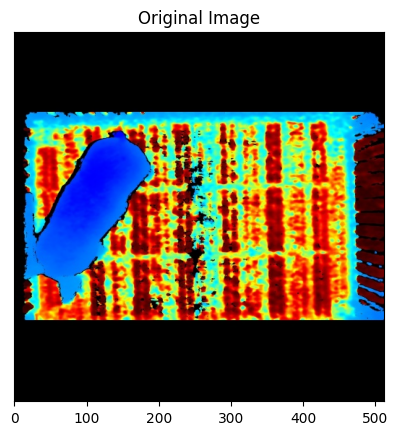

(512, 512)
(284, 512)
(284, 434)


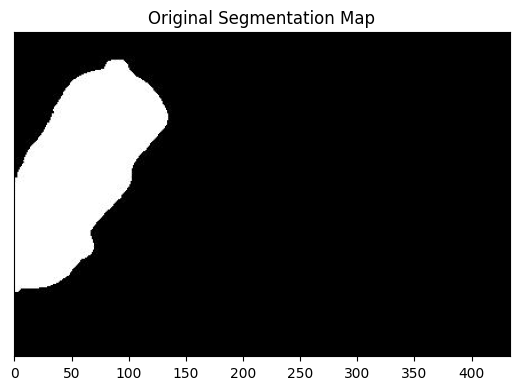

pig detected on left edge at:  [132, 0]
On edge
pig detected on left edge at:  [132, 0]
On edge


In [41]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random

def remove_border(img, border_ratio=0.21875):
    h, w = img.shape[:2]
    top_border = int(h * border_ratio)+2
    bottom_border = int(h * border_ratio)+2
    cropped_img = img[top_border:h-bottom_border, :]
    return cropped_img

def cropImage(image, top_ratio=0, bottom_ratio=1, left_ratio=0.10546875, right_ratio=0.953125):
    h, w = image.shape[:2]

    top = int(h * top_ratio)
    bottom = int(h * bottom_ratio)
    left = int(w * left_ratio)
    right = int(w * right_ratio)

    cropped = image[top:bottom, left:right]
    return cropped

# Randomly select an image
#random_image_path = random.choice(weeks['image_path'])
random_image_path = 'Week10/20211119/20211119_3342/_Depth_2627.jpg'
print(f"Selected image: {random_image_path}")

# Read and visualize the image
image = cv2.imread(random_image_path)
print(image.shape)
#image = remove_border(image)
print(image.shape)
#image = cropImage(image)
print(image.shape)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.yticks([])
plt.title('Original Image')
plt.show()
#cv2.imwrite('processed_original_image.png', image)

# Read and visualize the image
#image = cv2.imread('CROPPED_WEEK1-10_720_masks/'+random_image_path, cv2.IMREAD_GRAYSCALE)
image = cv2.imread('SQUARE_WEEK1-10_512_masks/'+random_image_path, cv2.IMREAD_GRAYSCALE)
print(image.shape)
image = remove_border(image)
print(image.shape)
image = cropImage(image)
print(image.shape)
plt.imshow(image, cmap='gray')
plt.yticks([]) 
plt.title('Original Segmentation Map')
plt.show()
#cv2.imwrite('segmentation_map_image.png', image)

# Detect pigs on the edges and visualize intermediate steps
edge = is_on_edge(image, count = 5)
if edge == 0:
  print('Not on edge')
else:
  print('On edge')
edge = is_on_edge(image, count = 10)
if edge == 0:
  print('Not on edge')
else:
  print('On edge')

In [70]:
weeks['pig_on_edge'] = 0

In [72]:
# Iterate through the entire DataFrame
for index, row in weeks.iterrows():
    image_path = row['image_path']
    print(f"Processing image: {image_path}")

    # Read the image
    image = cv2.imread('SQUARE_WEEK1-10_512_masks/'+image_path, cv2.IMREAD_GRAYSCALE)
    image = remove_border(image)
    #image = cropImage(image)

    # Detect pigs on the edges
    flag = is_on_edge(image, count = 10)

    weeks.at[index, 'pig_on_edge'] = flag

Streaming output truncated to the last 5000 lines.
Processing image: Week10/20211119/20211119_3384/_Depth_12041.jpg
pig detected on right edge at:  [172, 511]
Processing image: Week10/20211119/20211119_3384/_Depth_11896.jpg
Processing image: Week10/20211119/20211119_3384/_Depth_11172.jpg
Processing image: Week10/20211119/20211119_3384/_Depth_11942.jpg
pig detected on right edge at:  [87, 511]
Processing image: Week10/20211119/20211119_3384/_Depth_11892.jpg
Processing image: Week10/20211119/20211119_3384/_Depth_12075.jpg
Processing image: Week10/20211119/20211119_3384/_Depth_11869.jpg
Processing image: Week10/20211119/20211119_3384/_Depth_11322.jpg
pig detected on bottom edge at:  [283, 311]
Processing image: Week10/20211119/20211119_3384/_Depth_11887.jpg
Processing image: Week10/20211119/20211119_3384/_Depth_12024.jpg
pig detected on right edge at:  [161, 511]
Processing image: Week10/20211119/20211119_3384/_Depth_11889.jpg
Processing image: Week10/20211119/20211119_3384/_Depth_11128.j

In [107]:
weeks = weeks[weeks['pig_on_edge']==0]

In [109]:
weeks.to_csv('weeks_only_clean.csv')